In [1]:
kaggle=False


from transformers import DistilBertTokenizer, DistilBertModel
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
# models: https://github.com/huggingface/transformers/tree/main/examples/research_projects/distillation

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

path='/kaggle/input/clickbait-dataset/clickbait_data.csv' if kaggle else 'clickbait_data.csv'

df=pd.read_csv(path)
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


<Axes: >

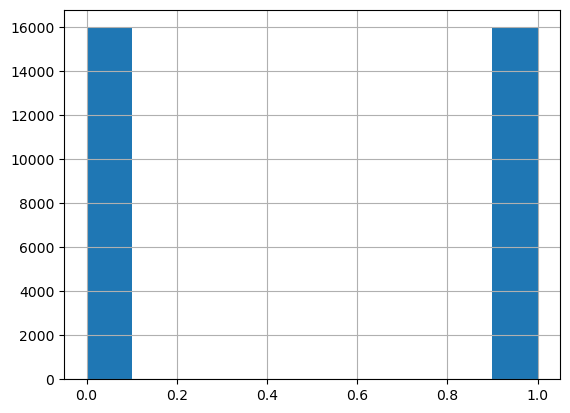

In [2]:
df["clickbait"].hist()

In [3]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['clickbait'])

In [4]:
# define dataset and dataloader

SEQ_LEN = 30

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text=self.df.iloc[idx]['headline']

        input_ids = tokenizer.encode(text, add_special_tokens=True)
        attention_mask = [1] * len(input_ids)

        if (len(input_ids)<SEQ_LEN):
            input_ids=input_ids+[0]*(SEQ_LEN-len(input_ids))
            attention_mask=attention_mask+[0]*(SEQ_LEN-len(attention_mask))
        elif (len(input_ids)>SEQ_LEN):
            input_ids=input_ids[:SEQ_LEN]
            attention_mask=attention_mask[:SEQ_LEN]
        label=self.df.iloc[idx]['clickbait']
        return torch.tensor(input_ids), torch.tensor(label), torch.tensor(attention_mask)
    
train_dataset = Dataset(train_df)
valid_dataset = Dataset(valid_df)






In [5]:

class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
        self.linear = torch.nn.Linear(768, 2)
        self.maxpool=torch.nn.MaxPool1d(SEQ_LEN)

    def forward(self, x, attention_mask=None):
        output = self.model(x, attention_mask=attention_mask)["last_hidden_state"]
        pooled_output = torch.mean(output, dim=1)
        output = self.linear(pooled_output)
        return output
    
my_model=Classifier()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for xb, yb, att_mask in train_dataloader:
    print(xb.shape)
    print(yb.shape)
    print(att_mask.shape)
    print(my_model(xb, attention_mask=att_mask).shape)
    break

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([32, 30])
torch.Size([32])
torch.Size([32, 30])
torch.Size([32, 2])


In [6]:
optimizer=torch.optim.AdamW(my_model.parameters(), lr=0.0001)
loss_fn=torch.nn.CrossEntropyLoss()
import neptune

class Learner():
    def __init__(self, model, optimizer, loss_fn, batch_size=32):
        self.model=model
        self.optimizer=optimizer
        self.loss_fn=loss_fn

        self.device=torch.device("cpu")
        if torch.cuda.is_available():
            self.device=torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device=torch.device("mps")

        self.model.to(self.device)
        #self.run=neptune.init_run(
        #    project="bernd.heidemann/clickbait-classification",
        #    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
        #)
        self.batch_size=batch_size
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=True)

    def fit(self, lr=0.001, epochs=10):
        #self.run["parameters"] = {
        #    "lr": lr,
        #    "epochs": epochs,
        #    "batch_size": self.batch_size,
        #}
        for epoch in range(epochs):
            self.model.train()

            # use tqdm for progress bar
            bar=tqdm(self.train_dataloader)
         
            for xb, yb, att_mask in bar:
                xb=xb.to(self.device)
                yb=yb.to(self.device)
                att_mask=att_mask.to(self.device)
                pred=self.model(xb, attention_mask=att_mask)
                loss=self.loss_fn(pred, yb)
                #self.run["train_loss"].log(loss.item())
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            self.model.eval()
            # log current state to neptune
            with torch.no_grad():
                valid_loss=0
                for xb, yb, att_mask in self.valid_dataloader:
                    xb=xb.to(self.device)
                    yb=yb.to(self.device)
                    att_mask=att_mask.to(self.device)
                    pred=self.model(xb, attention_mask=att_mask)
                    loss=self.loss_fn(pred, yb)
                    valid_loss+=loss.item()
                print("epoch: {}, valid_loss: {}".format(epoch, valid_loss/len(self.valid_dataloader)))
                #self.run["valid_loss"].log(valid_loss/len(self.valid_dataloader))
                
    def get_accuracy(self):
        self.model.eval()
        with torch.no_grad():
            correct=0
            for xb, yb, att_mask in self.valid_dataloader:
                xb=xb.to(self.device)
                yb=yb.to(self.device)
                att_mask=att_mask.to(self.device)
                pred=self.model(xb, attention_mask=att_mask)
                pred=torch.argmax(pred, dim=1)
                correct+=torch.sum(pred==yb).item()
            return correct/len(valid_dataset)

In [7]:
learner=Learner(my_model, optimizer, loss_fn, batch_size=128)
learner.fit(lr=0.0001, epochs=1)

  0%|          | 0/200 [00:00<?, ?it/s]

: 

In [ ]:
learner.get_accuracy()

0.98171875

In [ ]:
learner.run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/bernd.heidemann/clickbait-classification/e/CLIC-17/metadata
